In [1]:
%matplotlib inline
import math
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import torch
from scipy.stats import norm
from sklearn.datasets import fetch_openml
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from skorch import NeuralNetClassifier, NeuralNet
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader

from cml_data_tools.vae import VAE, vae_loss

/Users/stilljm/opt/miniconda3/envs/vae_experiments/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
def plot_example(X, y):
    """Plot the first 5 images and their labels in a row."""
    for i, (img, y) in enumerate(zip(X[:5].reshape(5, 28, 28), y[:5])):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
        plt.title(y)


def plot_reconstructions(X, n=5):
    for i, img in enumerate(X[:n].reshape(n, 28, 28)):
        plt.subplot(151 + i)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
    plt.show()

### Preamble
Fetch the data, split it, and plot a few images.

In [3]:
mnist = fetch_openml('mnist_784')

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X.min(), X.max(), X_train.shape, y_train.shape

(0.0, 1.0, (52500, 784), (52500,))

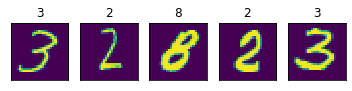

In [5]:
plot_example(X_train, y_train)

In [6]:
# Find a set with one from each digit
# 0 = 1
# 1 = 3
# 2 = 5
# 3 = 7
# 4 = 2
# 5 = 0
# 6 = 13
# 7 = 15
# 8 = 17
# 9 = 4
digits = X[[1, 3, 5, 7, 2, 0, 13, 15, 17, 4]]
digits.shape

(10, 784)

### Classifier
Just following the first part of the skorch [mnist tutorial](https://github.com/skorch-dev/skorch/blob/master/notebooks/MNIST.ipynb) to verify that everything is as it should be before building any VAE's.

In [7]:
mnist_dim = X.shape[1]
hidden_dim = mnist_dim // 8
output_dim = len(np.unique(mnist.target))

In [8]:
class ClassifierModule(nn.Module):
    def __init__(self, input_dim=784, hidden_dim=hidden_dim, output_dim=output_dim, dropout=0.5):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        self.hidden = nn.Linear(input_dim, hidden_dim)
        self.output = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, X, **kwargs):
        X = F.relu(self.hidden(X))
        X = self.dropout(X)
        X = F.softmax(self.output(X), dim=-1)
        return X

In [9]:
torch.manual_seed(42)
net = NeuralNetClassifier(ClassifierModule, max_epochs=20, lr=0.1, device='cpu')

In [10]:
net.fit(X_train, y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        0.8368       0.8834        0.4106  0.8806
      2        0.4315       0.9129        0.3087  0.8354
      3        0.3615       0.9244        0.2605  0.8480
      4        0.3221       0.9322        0.2353  0.8298
      5        0.2931       0.9372        0.2159  0.8293
      6        0.2676       0.9427        0.1990  0.8334
      7        0.2547       0.9466        0.1849  0.8171
      8        0.2414       0.9500        0.1727  0.8338
      9        0.2292       0.9517        0.1644  0.8368
     10        0.2188       0.9521        0.1627  0.8662
     11        0.2093       0.9551        0.1528  0.8319
     12        0.2038       0.9559        0.1465  0.8473
     13        0.1938       0.9572        0.1429  0.8765
     14        0.1906       0.9588        0.1367  0.8691
     15        0.1870       0.9587        0.1362  0.8418
     16        0.1805       0.9

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=ClassifierModule(
    (dropout): Dropout(p=0.5, inplace=False)
    (hidden): Linear(in_features=784, out_features=98, bias=True)
    (output): Linear(in_features=98, out_features=10, bias=True)
  ),
)

In [11]:
y_pred = net.predict(X_test)
accuracy_score(y_test, y_pred)

0.9626285714285714

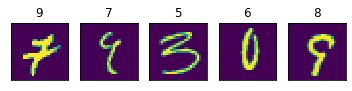

In [12]:
error_mask = y_pred != y_test
plot_example(X_test[error_mask], y_pred[error_mask])

# Train a VAE

Skorch has a [tutorial](https://nbviewer.jupyter.org/github/skorch-dev/skorch/blob/master/notebooks/Advanced_Usage.ipynb#Multiple-return-values-from-forward) on building an autoencoder; but the approach taken there isn't actually necessary if you use a `NeuralNet` directly rather than a subclass.

In [13]:
class MnistVAE(VAE):
    def __init__(self):
        encoder = nn.Sequential(nn.Linear(784, 400),
                                nn.ReLU())
        decoder = nn.Sequential(nn.Linear(20, 400),
                                nn.ReLU(),
                                nn.Linear(400, 784),
                                nn.Sigmoid())
        super().__init__(encoder, decoder, e=400, z=20)

In [14]:
class Criterion(nn.Module):
    def forward(self, y_pred, y_true):
        x_hat, mu, logvar = y_pred
        return vae_loss(y_true, x_hat, mu, logvar)

In [15]:
net = NeuralNet(MnistVAE,
                criterion=Criterion,
                optimizer=optim.Adam,
                lr=1e-3,
                max_epochs=100)

In [16]:
torch.manual_seed(120)

In [17]:
%time net.fit(X_train, y=X_train)

  epoch    train_loss    valid_loss     dur
-------  ------------  ------------  ------
      1    22795.2975    17764.5453  4.7221
      2    16450.6275    15709.3076  4.6681
      3    15175.2851    14870.3258  5.1804
      4    14640.2311    14562.7780  5.2746
      5    14356.0795    14357.3703  5.2592
      6    14160.7153    14160.8959  5.2622
      7    14024.9613    14055.1004  5.2558
      8    13917.4575    13936.4724  5.2992
      9    13841.0852    13876.8331  5.4224
     10    13770.4830    13834.0413  5.4274
     11    13717.6286    13773.8096  5.3334
     12    13667.0402    13733.1331  5.3506
     13    13627.9102    13678.0189  5.4097
     14    13585.1101    13673.0163  5.3695
     15    13553.1875    13674.8350  5.4835
     16    13532.2238    13625.8868  5.4508
     17    13498.5412    13616.6667  5.4553
     18    13469.5226    13580.2815  5.4544
     19    13449.4847    13577.6604  5.4951
     20    13432.9496    13556.3636  5.4697
     21    13410.1756    13550.4

<class 'skorch.net.NeuralNet'>[initialized](
  module_=MnistVAE(
    (encoder): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU()
    )
    (decoder): Sequential(
      (0): Linear(in_features=20, out_features=400, bias=True)
      (1): ReLU()
      (2): Linear(in_features=400, out_features=784, bias=True)
      (3): Sigmoid()
    )
    (mu): Linear(in_features=400, out_features=20, bias=True)
    (logvar): Linear(in_features=400, out_features=20, bias=True)
  ),
)

In [18]:
with torch.no_grad():
    sample = net.module_.decode(torch.randn(5, 20))
    sample = sample.detach().numpy()
sample.shape, len(np.unique(sample))    

((5, 784), 3920)

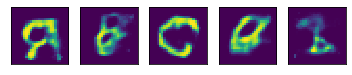

In [19]:
plot_reconstructions(sample)

# Sweep Variables

In [20]:
@torch.no_grad()
def sweep_variable_across_samples(vae, samples, i, sweep):
    """Sweeps a single latent variable
    
    Arguments
    ---------
    vae : torch.Module
        A VAE module; must have a decode method
    samples : n-by-z array-like
        Contains n samples of z latent variables
    i : int < z
        The latent variable to sweep
    sweep : array
        The values to use in sweeping z
    """
    # XXX dumb, unvectorized version
    recons = []
    for sample in samples:
        recons.append([])
        for val in sweep:
            sample[i] = val
            recons[-1].append(vae.decode(sample).detach().numpy())
    return np.array(recons)


@torch.no_grad()
def sweep_sample_across_variables(vae, sample, sweep):
    # XXX dumb unvectorized version; also one sweep for all vars
    recons = []
    for i, _ in enumerate(sample):
        recons.append([])
        for val in sweep:
            v = sample.clone()
            v[i] = val
            recons[-1].append(vae.decode(v).detach().numpy())
    return np.array(recons)


def plot_sweep_grid(recons):
    # n = number samples, m = number variables
    plt.figure(figsize=(12, 12))
    for (i, j) in product(range(10), range(10)):
        plt.subplot(10, 10, (10*i+1)+j)
        plt.imshow(recons[i][j].reshape(28, 28))
        plt.xticks([])
        plt.yticks([])
    plt.show()

In [21]:
samples = torch.randn(10, 20)
sweep = torch.linspace(-2, 2, steps=10)

### Sweeping one latent variable across 10 samples

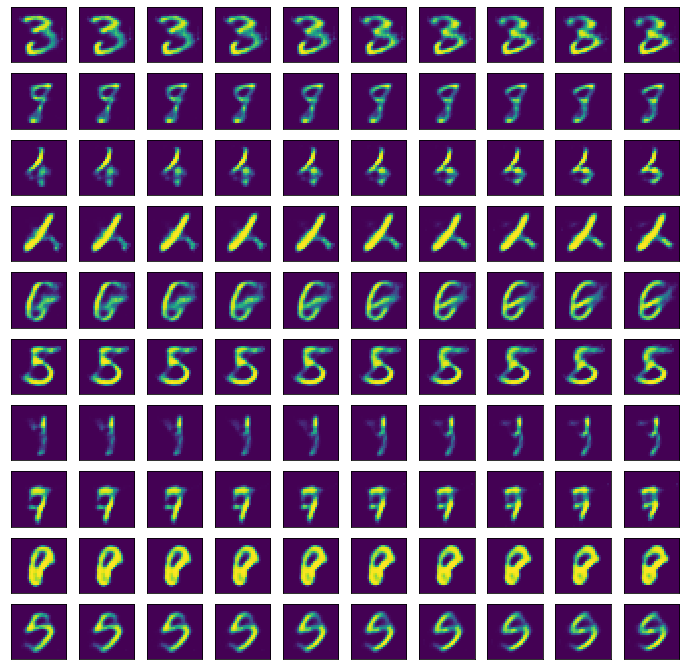

In [22]:
# Sweep the first latent variable across ten samples
recons_by_var = sweep_variable_across_samples(net.module_, samples, 1, sweep)
plot_sweep_grid(recons_by_var)

### Sweeping all 20 latent variables across 1 sample

In [23]:
recons_by_sample = sweep_sample_across_variables(net.module_, samples[0], sweep)
recons_by_sample.shape

(20, 10, 784)

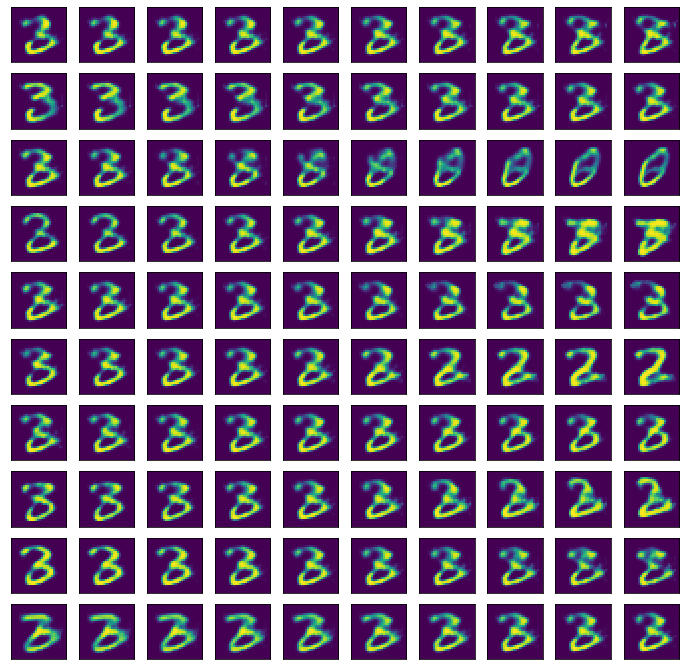

In [24]:
plot_sweep_grid(recons_by_sample[:10])

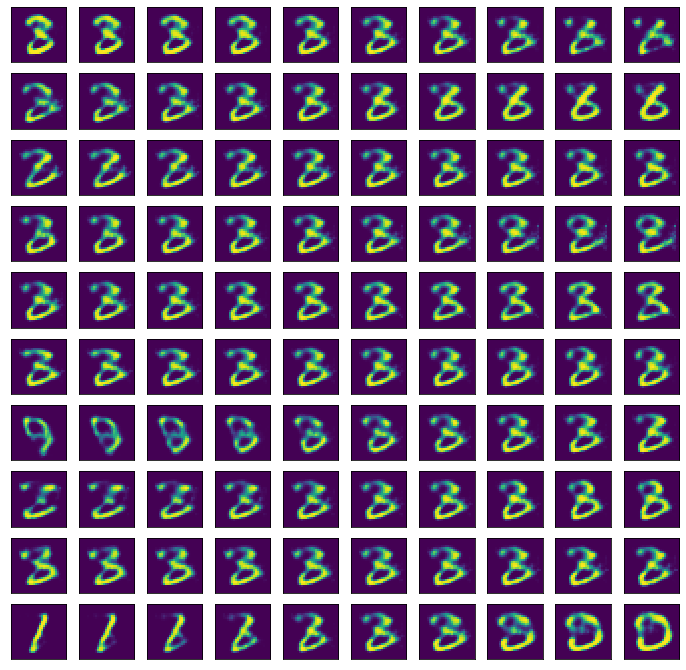

In [25]:
plot_sweep_grid(recons_by_sample[10:])

Sweeping reconstructions over latent variable no. 0


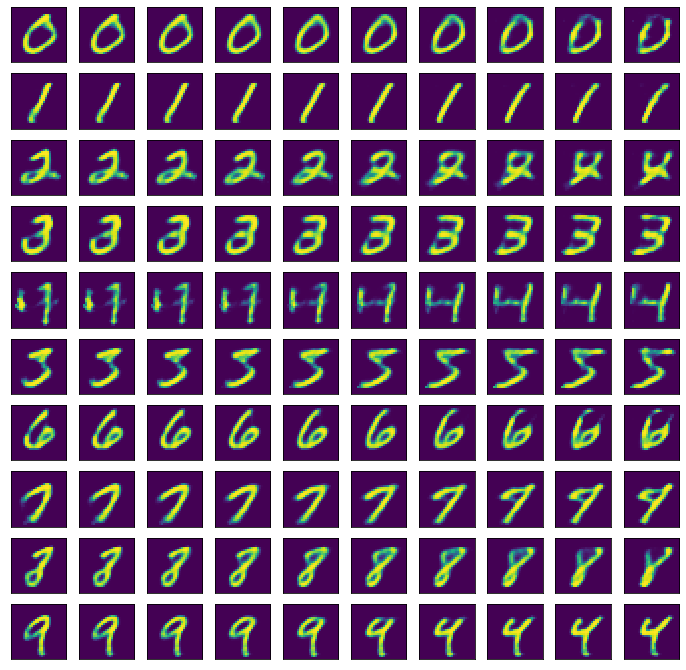

Sweeping reconstructions over latent variable no. 1


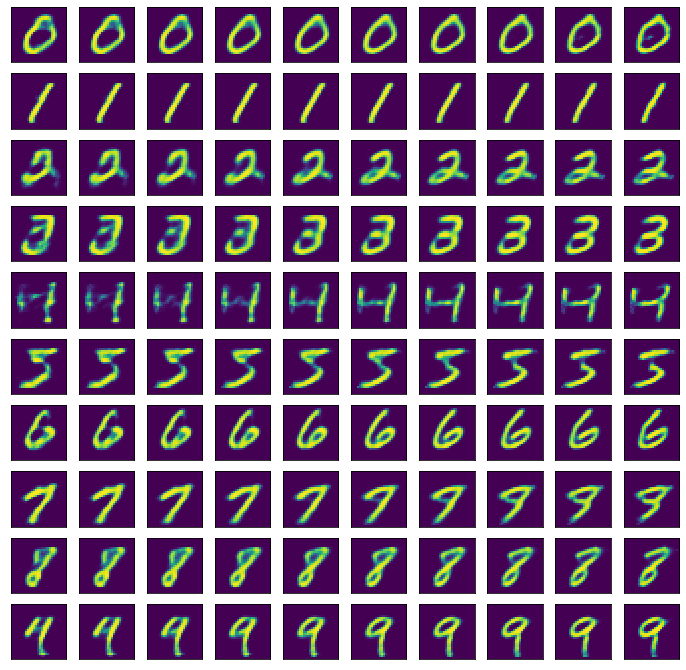

Sweeping reconstructions over latent variable no. 2


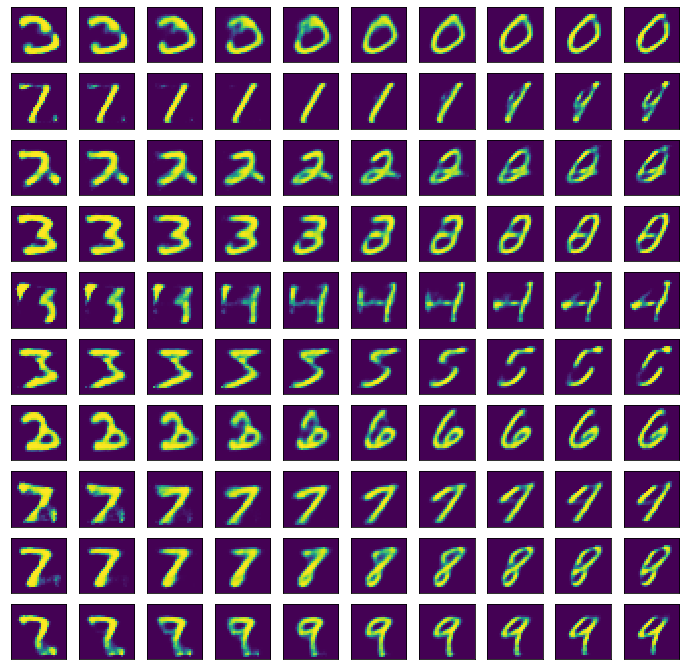

Sweeping reconstructions over latent variable no. 3


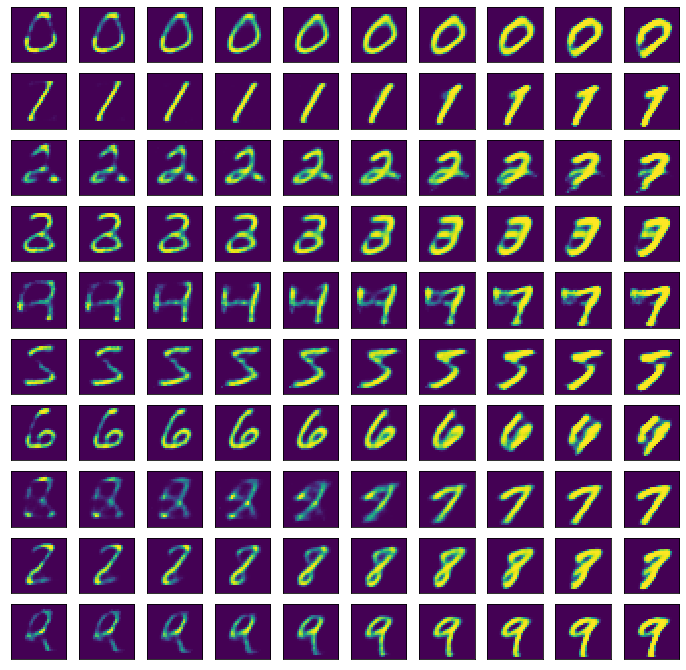

Sweeping reconstructions over latent variable no. 4


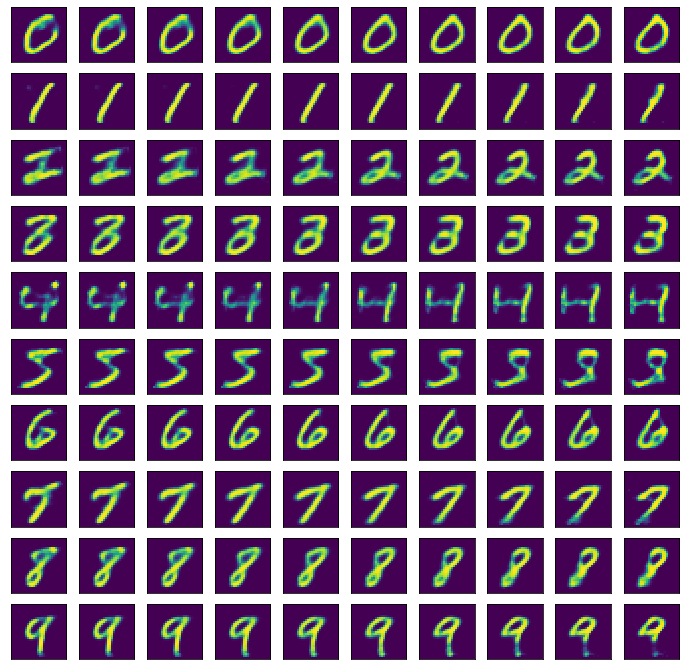

Sweeping reconstructions over latent variable no. 5


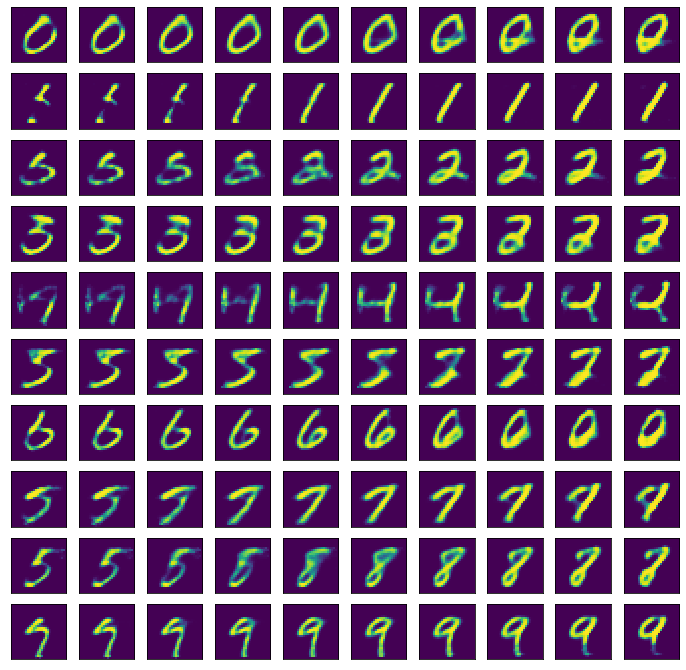

Sweeping reconstructions over latent variable no. 6


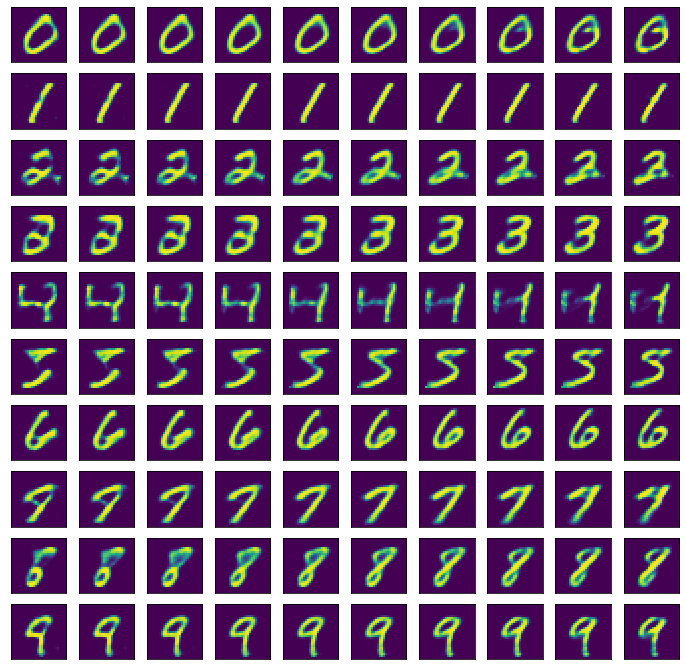

Sweeping reconstructions over latent variable no. 7


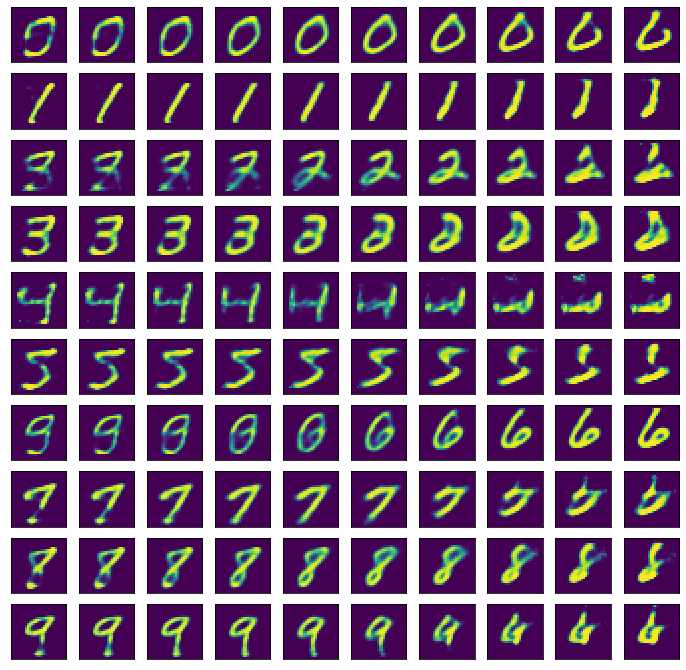

Sweeping reconstructions over latent variable no. 8


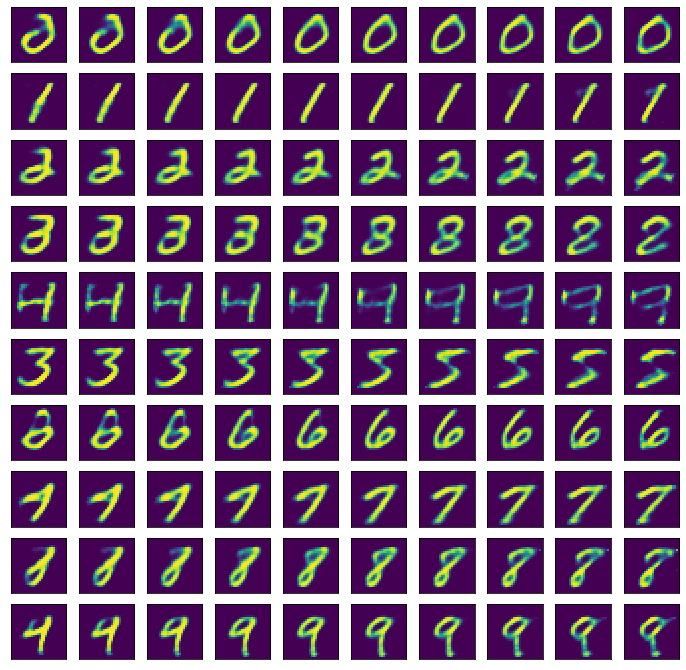

Sweeping reconstructions over latent variable no. 9


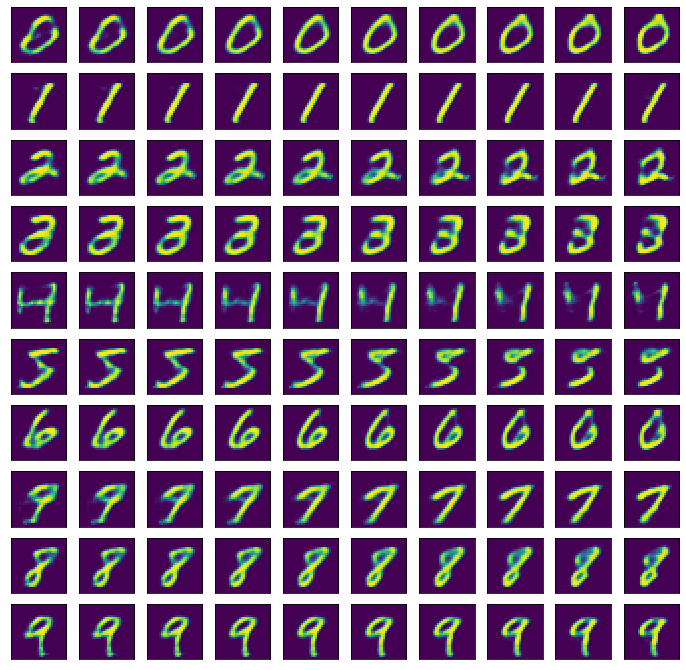

Sweeping reconstructions over latent variable no. 10


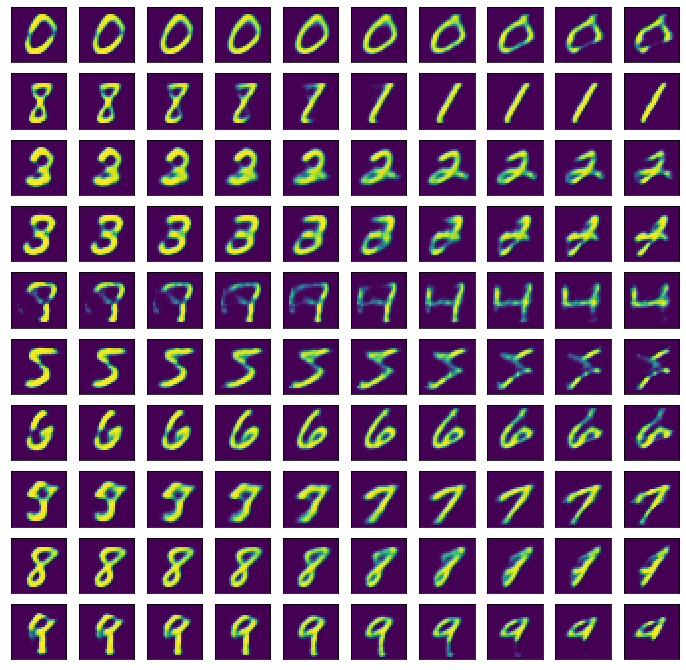

Sweeping reconstructions over latent variable no. 11


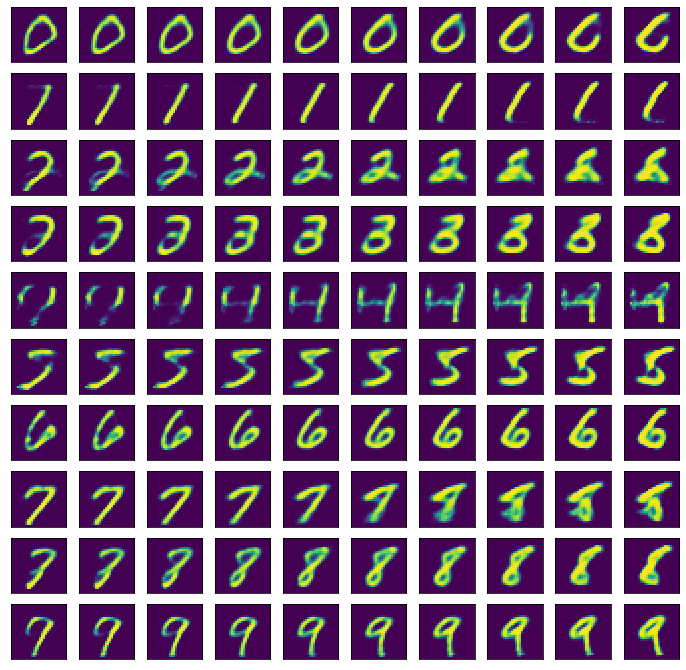

Sweeping reconstructions over latent variable no. 12


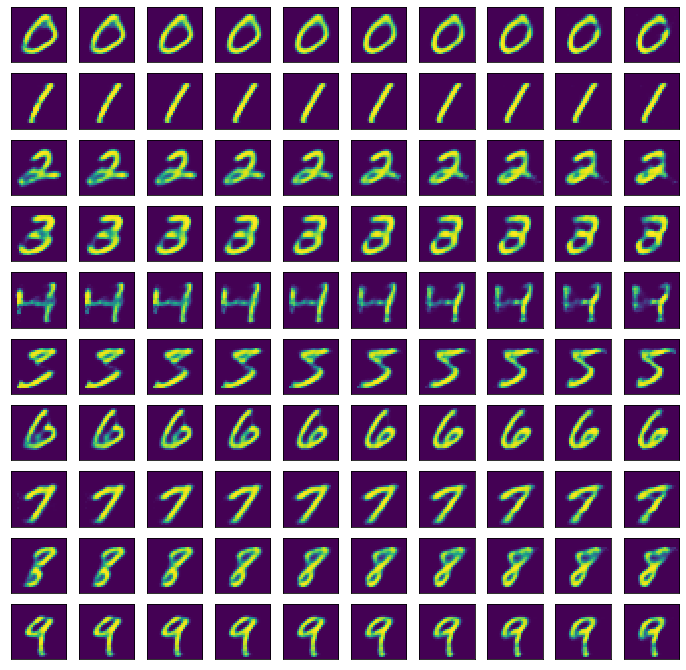

Sweeping reconstructions over latent variable no. 13


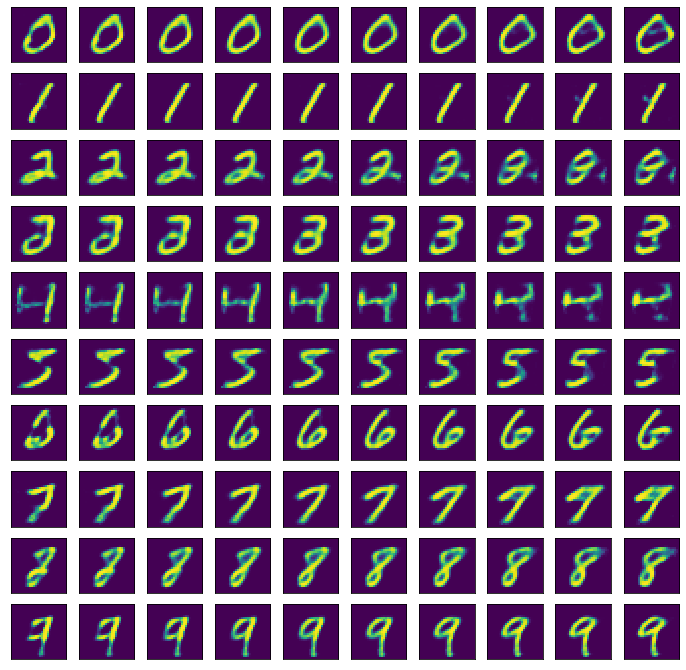

Sweeping reconstructions over latent variable no. 14


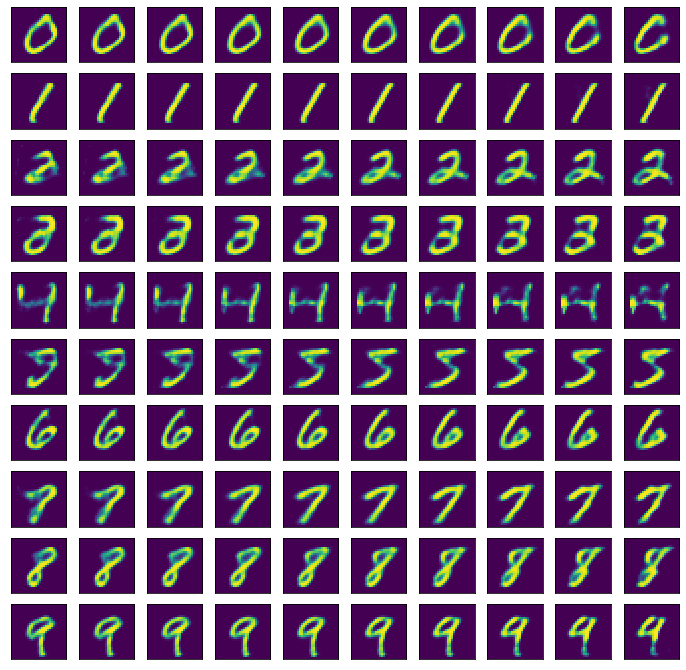

Sweeping reconstructions over latent variable no. 15


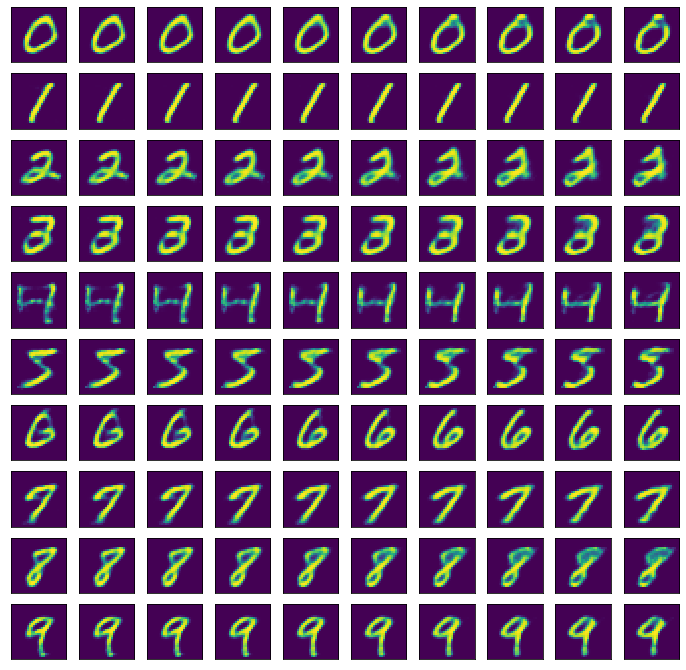

Sweeping reconstructions over latent variable no. 16


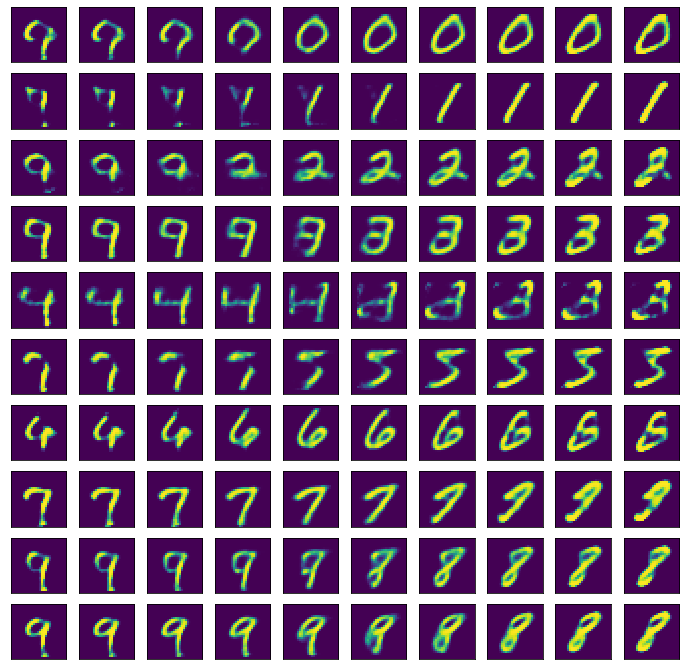

Sweeping reconstructions over latent variable no. 17


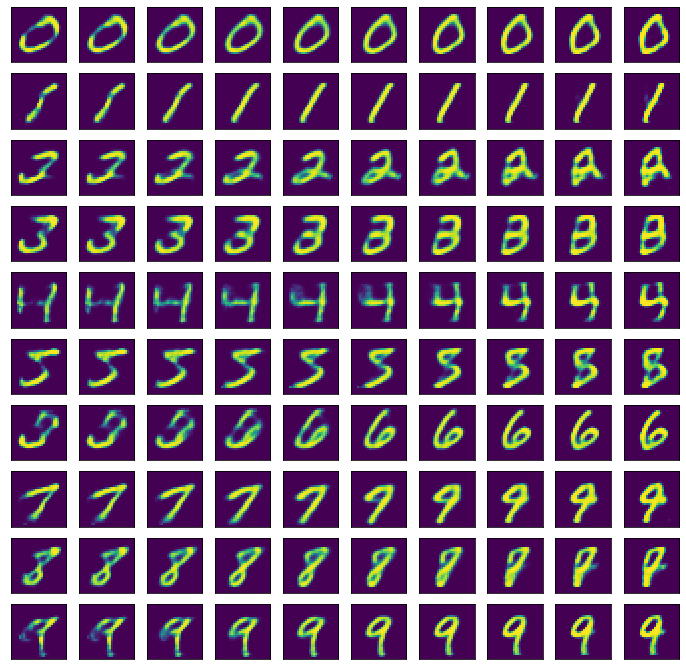

Sweeping reconstructions over latent variable no. 18


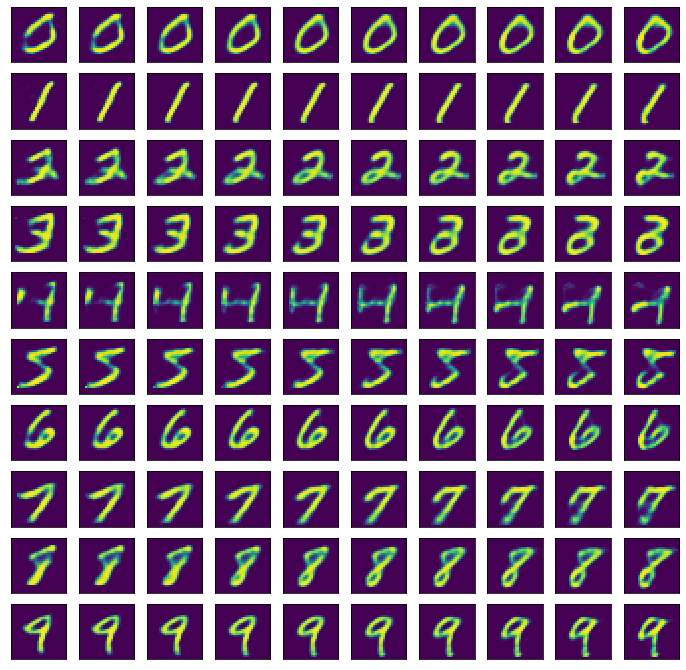

Sweeping reconstructions over latent variable no. 19


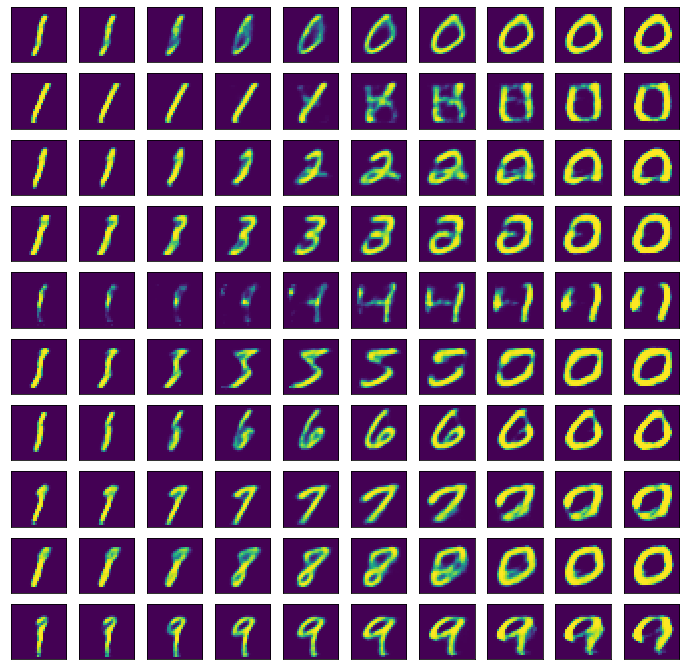

In [26]:
# Sweep across encodings of the actual digits
digit_encodings = net.module_.reparameterize(*net.module_.encode(torch.tensor(digits)))
sweep_range = torch.linspace(-4, 4, steps=10)

for i in range(20):
    print(f'Sweeping reconstructions over latent variable no. {i}')
    enc = digit_encodings.clone()
    recons_by_var = sweep_variable_across_samples(net.module_, enc, i, sweep_range)
    plot_sweep_grid(recons_by_var)

# Infer Latent Variable Distributions

In [27]:
@torch.no_grad()
def infer_latent_dists(X, vae, z_dim=20, resolution=1000, seed=42):
    dists = np.zeros((z_dim, resolution))
    lo = np.full((z_dim, 1), np.inf)
    hi = np.full((z_dim, 1), -np.inf)
    
    # Do before each iteration to repro them
    torch.manual_seed(seed)
    
    # XXX: can probably make faster by vectorizing and using another dimension
    for x in X:
        x = np.array([x])
        _, mu, lv = vae.forward(x)
        m = mu.detach().numpy().reshape(-1, 1)
        s = lv.detach().numpy().reshape(-1, 1)
        s = np.exp(0.5 * s)
        lo = np.minimum(lo, norm.ppf(0.01, loc=m, scale=s))
        hi = np.maximum(hi, norm.ppf(0.99, loc=m, scale=s))
        
    pts = np.linspace(lo.reshape(-1), hi.reshape(-1), num=resolution).T
    torch.manual_seed(seed)
    for x in X:
        x = np.array([x])
        _, mu, lv = vae.forward(x)
        m = mu.detach().numpy().reshape(-1, 1)
        s = lv.detach().numpy().reshape(-1, 1)
        s = np.exp(0.5 * s)
        dists += norm.pdf(pts, loc=m, scale=s)
        
    return pts, dists

In [28]:
def plot_latent_dists(X, net):
    xs, ys = infer_latent_dists(X, net)
    plt.figure(figsize=(15, 12))
    for (x, y) in zip(xs, ys):
        plt.plot(x, y)
    plt.show()

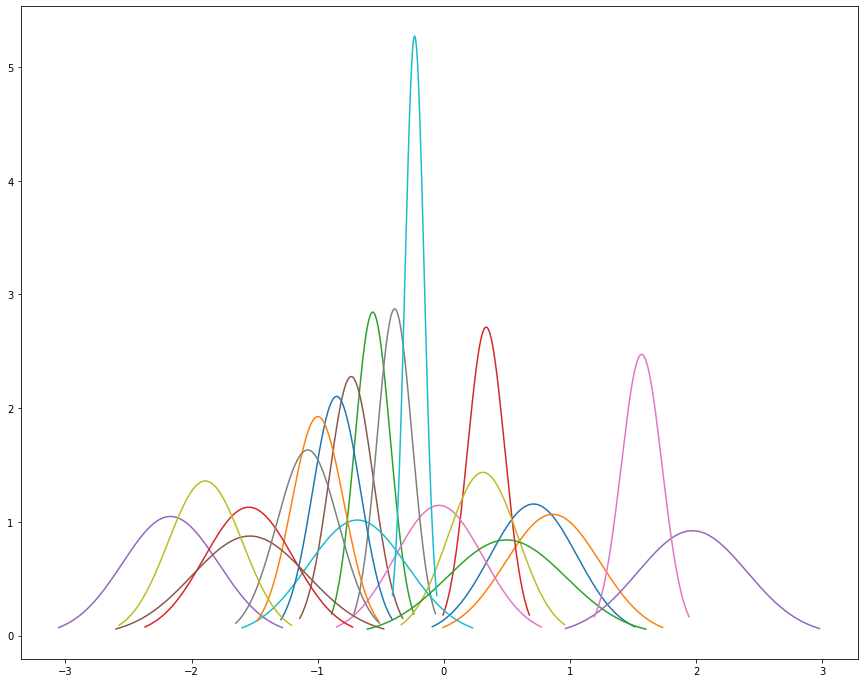

In [29]:
plot_latent_dists(X[:1], net)

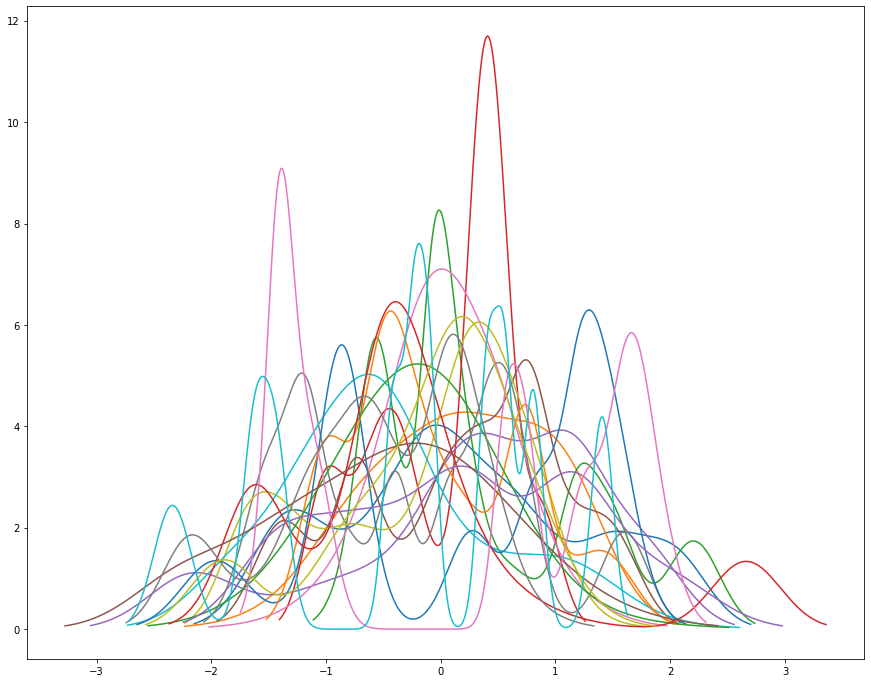

In [30]:
plot_latent_dists(X[:10], net)

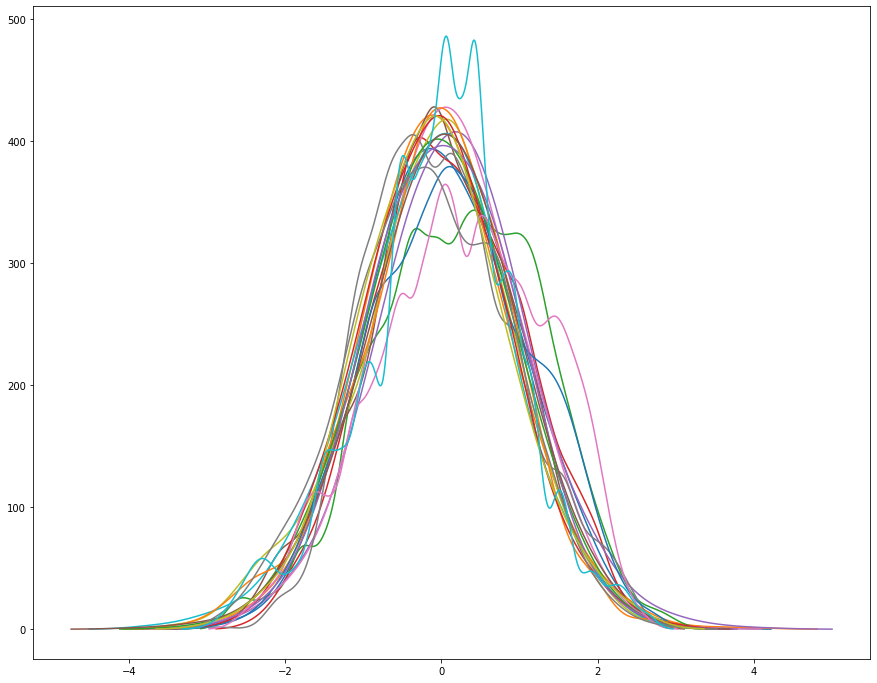

In [31]:
plot_latent_dists(X[:1000], net)

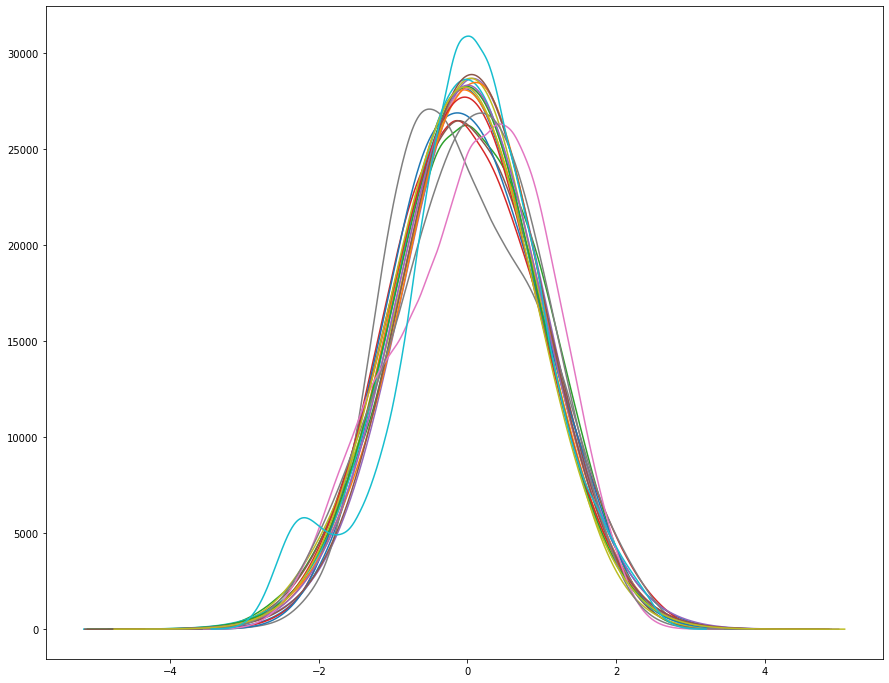

CPU times: user 15min 49s, sys: 6.82 s, total: 15min 56s
Wall time: 2min 40s


In [32]:
%time plot_latent_dists(X, net)